In [1]:
import pysubgroup as ps
import pandas as pd
from graph_pipeline.main import *
from tqdm.auto import tqdm
import numpy as np
import multiprocessing as mp
from itertools import product
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

def filter_on_stats(stat_df, min_replies=10, max_replies=350, language='en', acyclic=True):
    filter_array = np.logical_and(stat_df.replies >= min_replies ,stat_df.language == language)
    filter_array = np.logical_and(filter_array, stat_df.is_acyclic == acyclic)
    filter_array = np.logical_and(filter_array,stat_df.replies <= max_replies)
    filter_array = filter_array.to_numpy()
    return filter_array

def drop_useless(graph_feature_df):
    return graph_feature_df.drop(columns=["network_diameter", "network_radius", "closeness_centralization", "102", "111D", "111U", 
                                          "030C", "201", "120D", "120U", "120C", "210", "300" ])

In [2]:
graph_features_all = pd.read_pickle("b_collection_extracted/graph_features_all")
stat_df = pd.read_pickle("b_collection_extracted/stat_df")
result_df = pd.read_pickle("b_collection_extracted/document_result_df_25tops")
graph_features_all['replies'] = stat_df.set_index('thread_id').replies
clean_features = drop_useless(graph_features_all).drop(columns=["max_degree", "003"])
clean_features = clean_features[filter_on_stats(stat_df)]
stat_df = stat_df[filter_on_stats(stat_df)]
stat_df = stat_df.join(result_df.dominant_topic, on='thread_id')
clean_features = clean_features.join(result_df.dominant_topic).drop(columns="board")
clean_features_label = clean_features.join(result_df.labels)
clean_features_cluster = clean_features.join(pd.read_pickle("b_collection_extracted/result_df_dist_clust").km.drop(columns=['dominant_topic', 'labels', 'board']))
graph_features_clean = clean_features

# Dominant Topic als abhängige Variable

## Random Forests mit dominant topic

In [32]:
graph_features_all = graph_features_clean
scaler = StandardScaler()


clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(
    n_splits=5
)
cv_results_rf_topic_no = {}
for min_replies, max_replies in tqdm([(10, 50), (10, 100), (10, 350), (50,100), 
                                      (50, 150), (50, 250), (50, 350), (100, 150), 
                                      (100, 250), (100, 350), (150,250), (150, 350), 
                                      (200, 350), (250, 350)]):
    print(min_replies, max_replies)
    filter_array = filter_on_stats(stat_df, min_replies=min_replies, max_replies=max_replies)
    graph_features = clean_features[filter_array]
    graph_features = graph_features.dropna()
    X = graph_features.drop(columns=["dominant_topic", "replies"]).to_numpy()
    y = graph_features.dominant_topic.to_numpy()
    scaler.fit(X)
    X_transformed = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
    count = Counter(y_train)
    
    param_grid = { 
    'n_estimators': [50, 100, 125, 150, 175, 200],
    'max_features': ['auto'],
    'max_depth' : [10, 13, 15, None],
    'criterion' :['gini'],
    'class_weight': ['balanced', {label:1/count[label] for label in count.keys()}],
    'random_state': [42]
    }

    search = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        scoring='f1_macro', cv=cv,
        n_jobs=30, refit = True
    )
    search.fit(X_train, y_train)
    print(search.best_params_)
    key = f"{min_replies}-{max_replies}"
    cv_results_rf_topic_no[key] = {"model":search, 
                              'X_test': X_test, 
                              'X_train': X_train, 
                              'y_test':y_test, 
                              "y_train":y_train
                             }
    cv_results_rf_topic_no[key]['report'] = classification_report(cv_results_rf_topic_no[key]['y_test'], cv_results_rf_topic_no[key]['model'].predict(cv_results_rf_topic_no[key]['X_test']))
    cv_results_rf_topic_no[key]['report_dict'] = classification_report(cv_results_rf_topic_no[key]['y_test'], cv_results_rf_topic_no[key]['model'].predict(cv_results_rf_topic_no[key]['X_test']), output_dict=True)
    cv_results_rf_topic_no[key]['best_params'] = search.best_params_
    print(classification_report(cv_results_rf_topic_no[key]['y_test'], cv_results_rf_topic_no[key]['model'].predict(cv_results_rf_topic_no[key]['X_test'])))

  0%|          | 0/14 [00:00<?, ?it/s]

10 50


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {20: 0.0002852253280091272, 7: 0.0005422993492407809, 11: 0.00030525030525030525, 5: 0.00029342723004694836, 3: 0.0005672149744753262, 10: 0.0005777007510109763, 4: 0.0003003003003003003, 12: 0.00024084778420038535, 9: 0.00039277297721916735, 1: 0.00044464206313917296, 13: 0.0003104625892579944, 17: 0.000625, 15: 0.0010362694300518134, 22: 0.0005636978579481398, 0: 0.0007272727272727272, 24: 0.0015923566878980893, 18: 0.0005959475566150178, 2: 0.0005807200929152149, 19: 0.000496031746031746, 21: 0.0006112469437652812, 16: 0.0004677268475210477, 23: 0.0004048582995951417, 6: 0.00044603033006244426, 8: 0.0005537098560354374, 14: 0.002232142857142857}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 150, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.02      0.01      0.01       344
           1       0.07      0.03      0.04       562
           2       0.06      0.09      0.08       431
     

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {16: 0.0003756574004507889, 10: 0.00031466331025802394, 19: 0.00030211480362537764, 13: 0.00025967281225655674, 5: 0.00020296326364927948, 23: 0.0002498750624687656, 11: 0.00022675736961451248, 0: 0.000376081233546446, 4: 0.00010296540362438221, 24: 0.0009074410163339383, 6: 0.00032362459546925567, 9: 0.00027063599458728013, 3: 0.0003861003861003861, 1: 0.000328515111695138, 7: 0.0003322259136212625, 15: 0.00044742729306487697, 2: 0.00032509752925877764, 12: 0.00019113149847094801, 21: 0.0004640371229698376, 22: 0.00041476565740356696, 20: 0.0002003606491685033, 18: 0.0004342162396873643, 17: 0.00028376844494892167, 8: 0.00042408821034775233, 14: 0.0018083182640144665}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 175, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.22      0.13      0.16       664
           1       0.09      0.03      0.05       761
           2       0.27      0.22     

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 150, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.03      0.03      0.03       107
           1       0.12      0.06      0.08       139
           2       0.08      0.06      0.07       108
           3       0.07      0.09      0.08        92
           4       0.29      0.34      0.31       365
           5       0.08      0.02      0.04       252
           6       0.07      0.02      0.03       130
           7       0.10      0.07      0.08       145
           8       0.03      0.02      0.02        95
           9       0.17      0.05      0.08       170
          10       0.23      0.47      0.31       194
          11       0.11      0.13      0.12       219
          12       0.05      0.01      0.02       190
          13       0.04      0.06      0.05       130
          14       0.00      0.00      0.00        14
   

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': {17: 0.0007598784194528875, 9: 0.0019723865877712033, 10: 0.00205761316872428, 23: 0.001321003963011889, 6: 0.0038461538461538464, 5: 0.0018867924528301887, 22: 0.004201680672268907, 4: 0.0004079967360261118, 2: 0.0013280212483399733, 19: 0.0021008403361344537, 15: 0.0009794319294809011, 18: 0.004629629629629629, 1: 0.0038910505836575876, 20: 0.001996007984031936, 0: 0.001392757660167131, 24: 0.008695652173913044, 12: 0.0027247956403269754, 21: 0.005, 11: 0.002583979328165375, 7: 0.00267379679144385, 16: 0.005494505494505495, 13: 0.005076142131979695, 3: 0.005263157894736842, 8: 0.004784688995215311, 14: 0.02127659574468085}, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 42}


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0       0.35      0.44      0.39       179
           1       0.07      0.08      0.07        64
           2       0.35      0.53      0.43       188
           3       0.07      0.06      0.07        48
           4       0.66      0.59      0.62       613
           5       0.12      0.05      0.07       133
           6       0.06      0.05      0.05        65
           7       0.06      0.06      0.06        94
           8       0.07      0.04      0.05        52
           9       0.11      0.02      0.04       127
          10       0.35      0.51      0.41       122
          11       0.15      0.11      0.13        97
          12       0.06      0.03      0.04        92
          13       0.00      0.00      0.00        49
          14       0.00      0.00      0.00        12
          15       0.51      0.65      0.57       255
          16       0.04      0.04      0.04        46
          17       0.44    

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.36      0.44      0.39       249
           1       0.07      0.03      0.04        96
           2       0.42      0.53      0.47       268
           3       0.34      0.49      0.40       140
           4       0.76      0.73      0.74      1371
           5       0.14      0.06      0.08       203
           6       0.26      0.15      0.19       119
           7       0.20      0.18      0.18       194
           8       0.21      0.08      0.12        71
           9       0.03      0.01      0.02       172
          10       0.48      0.52      0.50       235
          11       0.07      0.06      0.06       122
          12       0.18      0.11      0.14       134
          13       0.03      0.04      0.03        57
          14       0.00      0.00      0.00        15
   

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': {5: 0.0026455026455026454, 4: 0.0002244668911335578, 17: 0.0010070493454179255, 20: 0.0022675736961451248, 10: 0.0017667844522968198, 2: 0.002320185614849188, 3: 0.0024154589371980675, 7: 0.002105263157894737, 0: 0.001736111111111111, 8: 0.007751937984496124, 13: 0.0136986301369863, 9: 0.0028169014084507044, 23: 0.0041841004184100415, 19: 0.0022727272727272726, 1: 0.005747126436781609, 18: 0.005747126436781609, 12: 0.004132231404958678, 24: 0.003401360544217687, 16: 0.010309278350515464, 11: 0.005847953216374269, 22: 0.00847457627118644, 6: 0.003875968992248062, 14: 0.03571428571428571, 15: 0.004975124378109453, 21: 0.009708737864077669}, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 150, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.31      0.51      0.39       144
           1       0.10      0.05      0.06        43
           2       0.66      0.60      0.63       108
           3    

In [33]:
with open("b_collection_extracted/rf_cv_results_rf_topic_no", "wb") as f:
    pickle.dump(cv_results_rf_topic_no, f)

In [125]:
with open("b_collection_extracted/rf_cv_results_rf_topic_no", "rb") as f:
    cv_results_rf_topic_no = pickle.load(f)

In [65]:
viz_dict_rf_topic_no = {"precision":{},
                        "precision_weighted":{},
                        "recall":{},
                        "recall_weighted":{},
                        "f1":{},
                        "f1_weigthed":{}
                       }
for key in cv_results_rf_topic_no.keys():
    df =  pd.DataFrame(cv_results_rf_topic_no[key]['report_dict']).transpose()
    viz_dict_rf_topic_no["precision"][key] = df.precision.loc["macro avg"]
    viz_dict_rf_topic_no["precision_weighted"][key] = df.precision.loc["weighted avg"]
    viz_dict_rf_topic_no["recall"][key] = df.recall.loc["macro avg"]
    viz_dict_rf_topic_no["recall_weighted"][key] = df.recall.loc["weighted avg"]
    viz_dict_rf_topic_no["f1"][key] = df["f1-score"].loc["macro avg"]
    viz_dict_rf_topic_no["f1_weigthed"][key] = df["f1-score"].loc["weighted avg"]


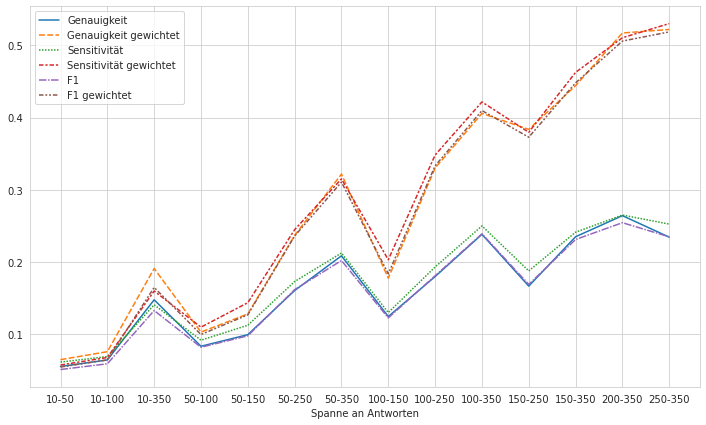

In [147]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(data=viz_dict_rf_topic_no).set_xlabel("Spanne an Antworten")
plt.legend(["Genauigkeit", "Genauigkeit gewichtet", "Sensitivität", "Sensitivität gewichtet", "F1", "F1 gewichtet"])

Text(0, 0.5, 'Tatsächliche Topic Nummer')

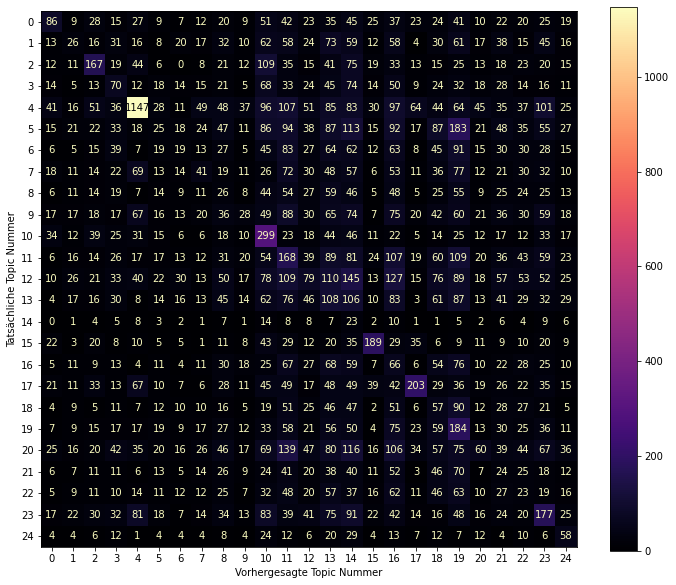

In [123]:
fig, ax = plt.subplots(figsize=(12,10))
g=plot_confusion_matrix(estimator=cv_results_rf_topic_no["10-350"]["model"], X=cv_results_rf_topic_no["10-350"]["X_test"], y_true=cv_results_rf_topic_no["10-350"]["y_test"],cmap="magma", ax=ax, xticks_rotation="horizontal")
g.ax_.set_xlabel('Vorhergesagte Topic Nummer')
g.ax_.set_ylabel('Tatsächliche Topic Nummer')

Text(0, 0.5, 'Tatsächliche Topic Nummer')

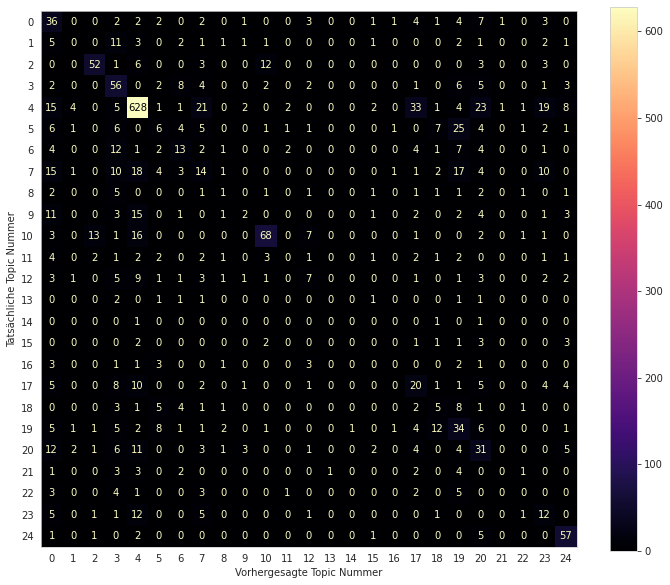

In [153]:
fig, ax = plt.subplots(figsize=(12,10))
g=plot_confusion_matrix(estimator=cv_results_rf_topic_no["250-350"]["model"], X=cv_results_rf_topic_no["250-350"]["X_test"], y_true=cv_results_rf_topic_no["250-350"]["y_test"],cmap="magma", ax=ax, xticks_rotation="horizontal")
g.ax_.set_xlabel('Vorhergesagte Topic Nummer')
g.ax_.set_ylabel('Tatsächliche Topic Nummer')

In [114]:
cv_results_rf_topic_no

{'10-50': {'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
               estimator=RandomForestClassifier(random_state=42), n_jobs=30,
               param_grid={'class_weight': ['balanced',
                                            {0: 0.0007272727272727272,
                                             1: 0.00044464206313917296,
                                             2: 0.0005807200929152149,
                                             3: 0.0005672149744753262,
                                             4: 0.0003003003003003003,
                                             5: 0.00029342723004694836,
                                             6: 0.00044603033006244426,
                                             7: 0...
                                             16: 0.0004677268475210477,
                                             17: 0.000625,
                                             18: 0.0005959475566150178,
            

In [141]:
multi_dict = {}
param_dict = {}
for key in cv_results_rf_topic_no.keys():
    multi_dict[key] = pd.DataFrame(cv_results_rf_topic_no[key]['report_dict'])
    param_dict[key] = cv_results_rf_topic_no[key]['best_params']
df = pd.concat(multi_dict.values(), keys=multi_dict.keys())
param_df = pd.DataFrame(param_dict)
df.round(2).to_excel("b_collection_extracted/classification_report_rf_topic_no.xlsx")
param_df.to_excel("b_collection_extracted/classification_params_rf_topic_no.xlsx")

In [134]:
param_df

,10-50,10-100,10-350,50-100,50-150,50-250,50-350,100-150,100-250,100-350,150-250,150-350,200-350,250-350
class_weight,"{20: 0.0002852253280091272, 7: 0.0005422993492...",balanced,"{16: 0.0003756574004507889, 10: 0.000314663310...",balanced,balanced,"{21: 0.0021598272138228943, 4: 0.0002955082742...",balanced,balanced,"{17: 0.0007598784194528875, 9: 0.0019723865877...",balanced,balanced,balanced,"{5: 0.0026455026455026454, 4: 0.00022446689113...","{4: 0.00032414910858995135, 17: 0.004016064257..."
criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini
max_depth,15,15,15,13,13,15,15,13,13,15,10,15,13,13
max_features,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto
n_estimators,150,200,175,150,150,125,175,125,200,100,100,50,150,150
random_state,42,42,42,42,42,42,42,42,42,42,42,42,42,42


## Explorative Analyse

### Binäre logistische Regression

In [11]:
import traceback

In [41]:
scaler = StandardScaler()

result_dict_stats_binary_no = {}
for min_replies, max_replies in tqdm([(10, 350)]):
    print(min_replies, max_replies)
    graph_features = clean_features.loc[filter_on_stats(stat_df=stat_df, min_replies=min_replies)]
    graph_features = graph_features.dropna()
    X = graph_features.drop(columns=["dominant_topic", "replies"]).astype(np.float64)
    y = graph_features.dominant_topic 
    scaler.fit(X)
    X_transformed = scaler.transform(X)
    key = f"{min_replies}-{max_replies}"
    result_dict_stats_binary_no[key] = {}
    try:
        temp_dict = {}
        for dominant_topic in [4, 15, 17] if min_replies == 10 else [2, 4, 24]:
            y_train_binary = y == dominant_topic
            print(min_replies, max_replies, dominant_topic)
            print(y_train_binary.sum())
            model = sm.Logit(endog=y_train_binary, exog=sm.add_constant(X))
            result = model.fit()
            temp_dict[dominant_topic] = {'model': model,
                                'result': result,
                                }
        result_dict_stats_binary_no[key]['predictors'] = temp_dict
    except Exception as e:
        print(f"EXCEPTION!!! {e} !!!")
        print(traceback.format_exc())
        continue

  0%|          | 0/1 [00:00<?, ?it/s]

10 350
10 350 4
12140
Optimization terminated successfully.
         Current function value: 0.296937
         Iterations 9
10 350 15
2794
Optimization terminated successfully.
         Current function value: 0.110225
         Iterations 9
10 350 17
4405
Optimization terminated successfully.
         Current function value: 0.169429
         Iterations 9


In [44]:
for min_replies in [10]:
    for key in result_dict_stats_binary_no[f"{min_replies}-350"]["predictors"].keys():
        print(key)
        pd.DataFrame(result_dict_stats_binary_no[f"{min_replies}-350"]["predictors"][key]["result"].summary().tables[1]).transpose().to_excel(f"b_collection_extracted/log_reg_result_topic_{min_replies}_top_{key}.xlsx")

4
15
17


### Subgroups

In [53]:
subgroup_dominant_topic = graph_features_clean.drop(columns="replies")

In [87]:
def search_subgroups(data, min_replies, target_attribute, target, a):
    result_dict = {}
    ps_target = ps.BinaryTarget(target_attribute=target_attribute, target_value=target)
    ps_search_space = ps.create_selectors(data, ignore=[target_attribute], nbins =30)
    ps_task = ps.SubgroupDiscoveryTask(data, ps_target, ps_search_space, qf=ps.GeneralizationAware_StandardQF(a))
    result_dict[f"{min_replies}_{target}_GA_{a}_SDFS"] = ps.SimpleDFS().execute(ps_task).to_dataframe()
    ps_task = ps.SubgroupDiscoveryTask(data, ps_target, ps_search_space, qf=ps.StandardQF(a))
    result_dict[f"{min_replies}_{target}_SQF_{a}_BFS"] = ps.BestFirstSearch().execute(ps_task).to_dataframe()
    return result_dict

In [88]:
subgroup_dominant_topic = graph_features_clean.drop(columns="replies")
subgroup_combs = []
[subgroup_combs.append(prod) for prod in product([10], ["dominant_topic"], [4, 15, 17], [0, 0.5, 1])]
[subgroup_combs.append(prod) for prod in product([250], ["dominant_topic"], [2, 4, 24], [0, 0.5, 1])]
pool = mp.Pool(processes=18)
subgroup_topic_results = [pool.apply_async(search_subgroups, (subgroup_dominant_topic.loc[filter_on_stats(stat_df, min_replies=item[0])], item[0], item[1], item[2], item[3],))
           for item in tqdm(subgroup_combs,desc="adding search to mp pool")]
subgroup_topic_results = [result.get() for result in tqdm(subgroup_topic_results, desc="retrieving subgroups")]

adding search to mp pool:   0%|          | 0/9 [00:00<?, ?it/s]

retrieving subgroups:   0%|          | 0/9 [00:00<?, ?it/s]

In [84]:
result_dict_sg_topic ={}

In [89]:

for sg_res in subgroup_topic_results:
    for res in sg_res.keys():
        result_dict_sg_topic[res]=sg_res[res]
        print(res)
        pprint(sg_res[res][["subgroup", "size_sg", "size_dataset", "target_share_sg", "target_share_dataset", "positives_sg", "positives_dataset", "lift"]])

250_2_SQF_0_BFS
                                            subgroup  size_sg  size_dataset  \
0  012: [0.01:0.01[ AND 021C: [0.00:0.00[ AND 030...      1.0        9822.0   
1  012: [0.01:0.01[ AND 021C: [0.00:0.00[ AND 030...      2.0        9822.0   
2  012: [0.01:0.01[ AND 021C<0.00 AND 030T: [0.00...      3.0        9822.0   
3  012: [0.01:0.01[ AND 021C<0.00 AND 021D: [0.00...      1.0        9822.0   
4  012: [0.01:0.01[ AND 021D: [0.00:0.00[ AND 030...      1.0        9822.0   
5  012: [0.01:0.01[ AND 021D: [0.00:0.00[ AND 030...      1.0        9822.0   
6  012: [0.01:0.01[ AND 021D: [0.00:0.00[ AND 030...      1.0        9822.0   
7  012: [0.01:0.01[ AND 021D: [0.00:0.00[ AND 030...      1.0        9822.0   
8             012: [0.01:0.01[ AND 021D: [0.00:0.00[      1.0        9822.0   
9  012: [0.01:0.01[ AND 021D: [0.00:0.00[ AND 030...      1.0        9822.0   

   target_share_sg  target_share_dataset  positives_sg  positives_dataset  \
0              1.0              0.040

In [102]:
result_dict_sg_topic
for res in result_dict_sg_topic.keys():
    print(res)
    pprint(result_dict_sg_topic[res])

10_4_GA_0_SDFS
    quality                                           subgroup  size_sg  \
0  0.884491  012: [0.09:0.10[ AND 021U: [0.15:0.19[ AND ave...      1.0   
1  0.884491  012: [0.09:0.10[ AND average_degree: [1.82:1.8...      1.0   
2  0.884491  021U: [0.07:0.08[ AND average_degree<1.82 AND ...      1.0   
3  0.884491          021U: [0.01:0.01[ AND average_degree<1.82      1.0   
4  0.884491          021D: [0.00:0.00[ AND average_degree<1.82      1.0   
5  0.884491  021U: [0.15:0.19[ AND average_degree: [1.82:1....      1.0   
6  0.884491  average_degree<1.82 AND betweenness_centraliza...      1.0   
7  0.884491  average_degree<1.82 AND betweenness_centraliza...      1.0   
8  0.884491  average_degree: [1.82:1.83[ AND degree_central...      1.0   
9  0.884491  021U: [0.07:0.08[ AND average_degree: [1.82:1....      1.0   

   size_dataset  positives_sg  positives_dataset  size_complement  \
0      105100.0           1.0            12140.0         105099.0   
1      105100.0      

In [81]:
sum(filter_on_stats(stat_df, min_replies=250))

9822

In [332]:
filter_array = filter_on_stats(stat_df, min_replies=10, max_replies=350)
for topic in tqdm([4, 15, 17]):
    a = 0
    bins = 30
    ps_target = ps.BinaryTarget(target_attribute='dominant_topic', target_value=topic)
    ps_search_space = ps.create_selectors(subgroup_dominant_topic[filter_array], ignore=['dominant_topic'], nbins =30)
    ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.GeneralizationAware_StandardQF(a))
    result_dict_10_dt[f"{topic}_GA_{a}_SDFS_bins={bins}"] = ps.SimpleDFS().execute(ps_task)
    ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.StandardQF(a))
    result_dict_10_dt[f"{topic}_SQF_{a}_BFS_bins={bins}"] = ps.BestFirstSearch().execute(ps_task)

  0%|          | 0/3 [00:00<?, ?it/s]

In [333]:
filter_array = filter_on_stats(stat_df, min_replies=250, max_replies=350)
for topic in tqdm([2, 4, 24]):
    a = 0
    bins = 30
    ps_target = ps.BinaryTarget(target_attribute='dominant_topic', target_value=topic)
    ps_search_space = ps.create_selectors(subgroup_dominant_topic[filter_array], ignore=['dominant_topic'], nbins =bins)
    ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.GeneralizationAware_StandardQF(a))
    result_dict_250_dt[f"{topic}_GA_{a}_SDFS_bins={bins}"] = ps.SimpleDFS().execute(ps_task)
    ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.StandardQF(a))
    result_dict_250_dt[f"{topic}_SQF_{a}_BFS_bins={bins}"] = ps.BestFirstSearch().execute(ps_task)


  0%|          | 0/3 [00:00<?, ?it/s]

In [216]:
result = result_dict_250_dt["2"]
result.to_dataframe()[["quality", "subgroup", "size_sg", "size_dataset", "positives_sg", "positives_dataset", "coverage_sg", "target_share_sg", "lift"]]

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,coverage_sg,target_share_sg,lift
0,0.098606,012: [0.01:0.01[,327.0,9822.0,190.0,399.0,0.476190,0.581040,14.303189
1,0.097490,021C: [0.00:0.00[,327.0,9822.0,188.0,399.0,0.471178,0.574924,14.152629
2,0.096932,degree_centralization: [0.72:0.83[,327.0,9822.0,187.0,399.0,0.468672,0.571865,14.077349
3,0.095525,012: [0.01:0.01[ AND 021C: [0.00:0.00[,290.0,9822.0,173.0,399.0,0.433584,0.596552,14.685040
4,0.095263,012: [0.01:0.01[ AND degree_centralization: [0...,282.0,9822.0,170.0,399.0,0.426065,0.602837,14.839759
5,0.095258,021U: [0.01:0.01[,327.0,9822.0,184.0,399.0,0.461153,0.562691,13.851510
6,0.094471,021U: [0.01:0.01[ AND degree_centralization: [...,283.0,9822.0,169.0,399.0,0.423559,0.597173,14.700337
7,0.093511,012: [0.01:0.01[ AND 021U: [0.01:0.01[ AND deg...,242.0,9822.0,154.0,399.0,0.385965,0.636364,15.665072
8,0.093497,021C: [0.00:0.00[ AND degree_centralization: [...,251.0,9822.0,157.0,399.0,0.393484,0.625498,15.397598
9,0.092859,012: [0.01:0.01[ AND 021U: [0.01:0.01[,245.0,9822.0,154.0,399.0,0.385965,0.628571,15.473255


# Cluster als abhängige Variable

## Random Forests

In [50]:
graph_features_all = clean_features_cluster
graph_features_all['replies'] = stat_df.set_index('thread_id').replies
scaler = StandardScaler()


clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(
    n_splits=5
)
cv_results_rf_cluster = {}
for min_replies, max_replies in tqdm([(10, 50), (10, 100), (10, 350), (50,100), 
                                      (50, 150), (50, 250), (50, 350), (100, 150), 
                                      (100, 250), (100, 350), (150,250), (150, 350), 
                                      (200, 350), (250, 350)]):
    print(min_replies, max_replies)
    filter_array = filter_on_stats(stat_df, min_replies=min_replies, max_replies=max_replies)
    graph_features = graph_features_all.loc[filter_array]
    graph_features = graph_features.dropna()
    X = graph_features.drop(columns=["km", "replies", "dominant_topic"]).to_numpy()
    y = graph_features.km.to_numpy()
    scaler.fit(X)
    X_transformed = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
    count = Counter(y_train)
    
    param_grid = { 
    'n_estimators': [50, 100, 125, 150, 175, 200],
    'max_features': ['auto'],
    'max_depth' : [10, 13, 15, None],
    'criterion' :['gini'],
    'class_weight': ['balanced', {label:1/count[label] for label in count.keys()}],
    'random_state': [42]
    }

    search = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        scoring='f1_macro', cv=cv,
        n_jobs=20, refit = True
    )
    search.fit(X_train, y_train)
    print(search.best_params_)
    key = f"{min_replies}-{max_replies}"
    cv_results_rf_cluster[key] = {"model":search, 
                      'X_test': X_test, 
                      'X_train': X_train, 
                      'y_test':y_test, 
                      "y_train":y_train
                     }
    cv_results_rf_cluster[key]['report'] = classification_report(cv_results_rf_cluster[key]['y_test'], cv_results_rf_cluster[key]['model'].predict(cv_results_rf_cluster[key]['X_test']))
    cv_results_rf_cluster[key]['report_dict'] = classification_report(cv_results_rf_cluster[key]['y_test'], cv_results_rf_cluster[key]['model'].predict(cv_results_rf_cluster[key]['X_test']), output_dict=True)
    cv_results_rf_cluster[key]['best_params'] = search.best_params_
    print(classification_report(cv_results_rf_cluster[key]['y_test'], cv_results_rf_cluster[key]['model'].predict(cv_results_rf_cluster[key]['X_test'])))

  0%|          | 0/14 [00:00<?, ?it/s]

10 50
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 175, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.12      0.18      0.14      1004
           1       0.06      0.09      0.07       639
           2       0.04      0.07      0.05        68
           3       0.08      0.31      0.12       556
           4       0.81      0.48      0.60     10362
           5       0.03      0.15      0.06       141
           6       0.04      0.05      0.04       578
           7       0.01      0.24      0.02        33

    accuracy                           0.41     13381
   macro avg       0.15      0.20      0.14     13381
weighted avg       0.64      0.41      0.49     13381

10 100


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.15      0.22      0.17      1297
           1       0.07      0.08      0.08       830
           2       0.11      0.31      0.17       175
           3       0.11      0.34      0.16       742
           4       0.81      0.50      0.62     11894
           5       0.07      0.22      0.11       244
           6       0.05      0.10      0.07       682
           7       0.01      0.20      0.02        50

    accuracy                           0.42     15914
   macro avg       0.17      0.25      0.17     15914
weighted avg       0.63      0.42      0.49     15914

10 350


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {4: 1.743922430330299e-05, 0: 0.00015019525382997898, 1: 0.00023696682464454977, 6: 0.00033500837520938025, 3: 0.00023980815347721823, 2: 0.00016204829039053638, 5: 0.0005399568034557236, 7: 0.001466275659824047}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 175, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.16      0.19      0.18      1664
           1       0.08      0.07      0.07      1055
           2       0.67      0.77      0.72      1543
           3       0.17      0.34      0.22      1043
           4       0.78      0.60      0.68     14335
           5       0.26      0.31      0.28       463
           6       0.05      0.15      0.08       746
           7       0.16      0.49      0.24       171

    accuracy                           0.52     21020
   macro avg       0.29      0.36      0.31     21020
weighted avg       0.62      0.52      0.56     21020

50 100
{'class_

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 125, 'random_state': 42}


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0       0.27      0.14      0.18       263
           1       0.11      0.04      0.06       150
           2       0.81      0.76      0.78      1269
           3       0.38      0.56      0.46       216
           4       0.69      0.80      0.74      1843
           5       0.73      0.47      0.57       164
           6       0.00      0.00      0.00        38
           7       0.60      0.58      0.59       110

    accuracy                           0.68      4053
   macro avg       0.45      0.42      0.42      4053
weighted avg       0.65      0.68      0.66      4053

200 350
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.19      0.29      0.23       188
           1       0.11      0.14      0.12       106
           2       0.82      0.81      0.81   

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [51]:
with open("b_collection_extracted/rf_cv_results_rf_cluster", "wb") as f:
    pickle.dump(cv_results_rf_cluster, f)

In [136]:
with open("b_collection_extracted/rf_cv_results_rf_cluster", "rb") as f:
    cv_results_rf_cluster = pickle.load(f)

In [142]:
multi_dict = {}
param_dict = {}
for key in cv_results_rf_cluster.keys():
    multi_dict[key] = pd.DataFrame(cv_results_rf_cluster[key]['report_dict'])
    param_dict[key] = cv_results_rf_cluster[key]['best_params']
df = pd.concat(multi_dict.values(), keys=multi_dict.keys())
param_df = pd.DataFrame(param_dict)
df.round(2).to_excel("b_collection_extracted/classification_report_rf_cluster.xlsx")
param_df.to_excel("b_collection_extracted/classification_params_rf_cluster.xlsx")

In [57]:
viz_dict_rf_cluster = {"precision":{},
                        "precision_weighted":{},
                        "recall":{},
                        "recall_weighted":{},
                        "f1":{},
                        "f1_weigthed":{}
                       }
for key in cv_results_rf_cluster.keys():
    df =  pd.DataFrame(cv_results_rf_cluster[key]['report_dict']).transpose()
    viz_dict_rf_cluster["precision"][key] = df.precision.loc["macro avg"]
    viz_dict_rf_cluster["precision_weighted"][key] = df.precision.loc["weighted avg"]
    viz_dict_rf_cluster["recall"][key] = df.recall.loc["macro avg"]
    viz_dict_rf_cluster["recall_weighted"][key] = df.recall.loc["weighted avg"]
    viz_dict_rf_cluster["f1"][key] = df["f1-score"].loc["macro avg"]
    viz_dict_rf_cluster["f1_weigthed"][key] = df["f1-score"].loc["weighted avg"]


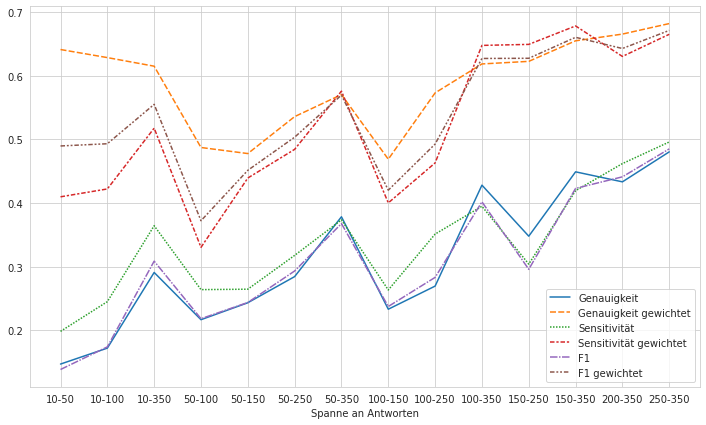

In [150]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(data=viz_dict_rf_cluster).set_xlabel("Spanne an Antworten")
plt.legend(["Genauigkeit", "Genauigkeit gewichtet", "Sensitivität", "Sensitivität gewichtet", "F1", "F1 gewichtet"])

In [331]:
pd.DataFrame(cv_results_rf_cluster["10-350"]['report_dict']).transpose().round(2).join(pd.DataFrame(cv_results_rf_cluster["250-350"]['report_dict']).transpose().round(2), lsuffix=" (10-350)", rsuffix=" (250-350)", how="left").to_excel("b_collection_extracted/classification_report_rf_cluster_10-350_250-350.xlsx")

[Text(0, 0, 'Beziehung'),
 Text(1, 0, 'Rassismus'),
 Text(2, 0, 'Social'),
 Text(3, 0, 'Politik'),
 Text(4, 0, 'Bilder'),
 Text(5, 0, 'roll'),
 Text(6, 0, 'Konsum'),
 Text(7, 0, 'kik')]

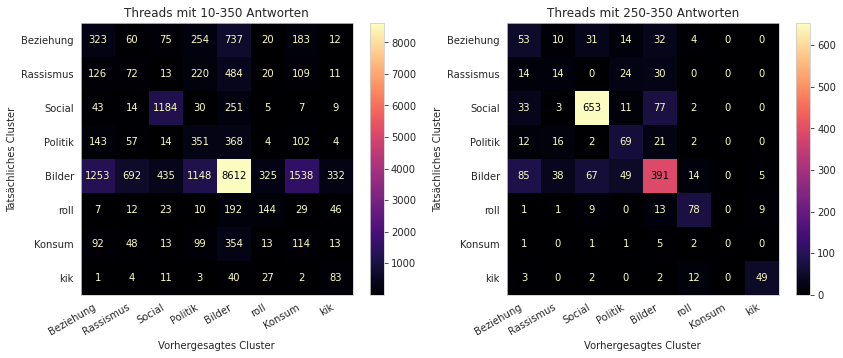

In [330]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
g1=plot_confusion_matrix(estimator=cv_results_rf_cluster["10-350"]["model"], X=cv_results_rf_cluster["10-350"]["X_test"], y_true=cv_results_rf_cluster["10-350"]["y_test"],cmap="magma", ax=ax1, display_labels=["Beziehung", "Rassismus", "Social", "Politik","Bilder", "roll", "Konsum", "kik"])
g1.ax_.set_xlabel('Vorhergesagtes Cluster')
g1.ax_.set_ylabel('Tatsächliches Cluster')
g1.ax_.set_title("Threads mit 10-350 Antworten")
g1.ax_.tick_params(axis='x', labelrotation=30)
g1.ax_.set_xticklabels(["Beziehung", "Rassismus", "Social", "Politik","Bilder", "roll", "Konsum", "kik"], horizontalalignment="right")
g2=plot_confusion_matrix(estimator=cv_results_rf_cluster["250-350"]["model"], X=cv_results_rf_cluster["250-350"]["X_test"], y_true=cv_results_rf_cluster["250-350"]["y_test"],cmap="magma", ax=ax2, display_labels=["Beziehung", "Rassismus", "Social", "Politik","Bilder", "roll", "Konsum", "kik"])
g2.ax_.set_xlabel('Vorhergesagtes Cluster')
g2.ax_.set_ylabel('Tatsächliches Cluster')
g2.ax_.set_title("Threads mit 250-350 Antworten")
g2.ax_.tick_params(axis='x', labelrotation=30)
g2.ax_.set_xticklabels(["Beziehung", "Rassismus", "Social", "Politik","Bilder", "roll", "Konsum", "kik"], horizontalalignment="right")

## Explorative Analyse

## binäre logistische Regression

In [49]:
scaler = StandardScaler()

result_dict_stats_binary_cluster = {}
for min_replies, max_replies in tqdm([(10, 350)]):
    print(min_replies, max_replies)
    filter_array = filter_on_stats(stat_df, min_replies=min_replies)
    graph_features = clean_features_cluster.loc[filter_array]
    graph_features = graph_features.dropna()
    X = graph_features.drop(columns=["km", "replies", "dominant_topic"]).astype(np.float64)
    y = graph_features.km 
    scaler.fit(X)
    X_transformed = scaler.transform(X)
    key = f"{min_replies}-{max_replies}"
    result_dict_stats_binary_cluster[key] = {}
    try:
        temp_dict = {}
        for dominant_topic in [2, 4, 5] if min_replies == 10 else [2, 5, 7]:
            y_train_binary = y == dominant_topic
            print(min_replies, max_replies)
            print(y_train_binary.sum())
            model = sm.Logit(endog=y_train_binary, exog=sm.add_constant(X))
            result = model.fit()
            temp_dict[dominant_topic] = {'model': model,
                                'result': result,
                                }
        result_dict_stats_binary_cluster[key]['predictors'] = temp_dict
    except Exception as e:
        print(f"EXCEPTION!!! {e} !!!")
        continue

  0%|          | 0/1 [00:00<?, ?it/s]

10 350
10 350
7714
Optimization terminated successfully.
         Current function value: 0.135757
         Iterations 20
10 350
71677
Optimization terminated successfully.
         Current function value: 0.567960
         Iterations 7
10 350
2315
Optimization terminated successfully.
         Current function value: 0.079520
         Iterations 13


In [50]:
for min_replies in [10]:
    for key in result_dict_stats_binary_cluster[f"{min_replies}-350"]["predictors"].keys():
        print(key)
        pd.DataFrame(result_dict_stats_binary_cluster[f"{min_replies}-350"]["predictors"][key]["result"].summary().tables[1]).transpose().to_excel(f"b_collection_extracted/log_reg_result_cluster_{min_replies}_top_{key}.xlsx")

2
4
5


### Subgroups von Clustern

In [93]:
subgroup_dominant_topic = clean_features_cluster.drop(columns=["replies", "dominant_topic"])
subgroup_combs = []
#[subgroup_combs.append(prod) for prod in product([10], ["km"], [2, 4, 5], [0, 0.5, 1])]
[subgroup_combs.append(prod) for prod in product([250], ["km"], [2, 5, 7], [0, 0.5, 1])]
pool = mp.Pool(processes=18)
sg_cluster_results = [pool.apply_async(search_subgroups, (subgroup_dominant_topic.loc[filter_on_stats(stat_df, min_replies=item[0])], item[0], item[1], item[2], item[3],))
           for item in tqdm(subgroup_combs,desc="adding search to mp pool")]
sg_cluster_results = [result.get() for result in tqdm(sg_cluster_results, desc="retrieving subgroups")]

adding search to mp pool:   0%|          | 0/9 [00:00<?, ?it/s]

retrieving subgroups:   0%|          | 0/9 [00:00<?, ?it/s]

In [106]:
res.split("_")[3]

'1'

In [108]:
"250_2_SQF_0.5_BFS".split("_")

['250', '2', 'SQF', '0.5', 'BFS']

In [107]:

for sg_res in sg_cluster_results:
    for res in sg_res.keys():
        print(res)
        pprint(sg_res[res][["subgroup", "size_sg", "size_dataset", "target_share_sg", "target_share_dataset", "positives_sg", "positives_dataset", "lift"]])

250_2_SQF_0_BFS
                                            subgroup  size_sg  size_dataset  \
0  012: [0.02:0.02[ AND 021C: [0.00:0.00[ AND 021...      1.0        9822.0   
1  012: [0.02:0.02[ AND 021C: [0.00:0.00[ AND 021...      1.0        9822.0   
2  012: [0.02:0.02[ AND 021C: [0.00:0.00[ AND 030...      1.0        9822.0   
3             012: [0.02:0.02[ AND 021C: [0.00:0.00[      1.0        9822.0   
4  012: [0.02:0.02[ AND 021C: [0.00:0.00[ AND 021...      1.0        9822.0   
5  012: [0.02:0.02[ AND 021D: [0.00:0.00[ AND 030...      1.0        9822.0   
6  012: [0.02:0.02[ AND 021C: [0.00:0.00[ AND 030...      1.0        9822.0   
7  012: [0.02:0.02[ AND 021U: [0.00:0.00[ AND 030...      1.0        9822.0   
8  012: [0.02:0.02[ AND 021D: [0.00:0.00[ AND 021...      1.0        9822.0   
9             012: [0.02:0.02[ AND 030T: [0.00:0.00[      1.0        9822.0   

   target_share_sg  target_share_dataset  positives_sg  positives_dataset  \
0              1.0              0.396

In [103]:
%whos

Variable                           Type                    Data/Info
--------------------------------------------------------------------
Counter                            type                    <class 'collections.Counter'>
GridSearchCV                       ABCMeta                 <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LogisticRegression                 type                    <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
RandomForestClassifier             ABCMeta                 <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
StandardScaler                     type                    <class 'sklearn.preproces<...>ng._data.StandardScaler'>
StratifiedKFold                    ABCMeta                 <class 'sklearn.model_sel<...>._split.StratifiedKFold'>
X                                  DataFrame                          average_degree<...>105100 rows x 12 columns]
X_transformed                      ndarray                 105100x12: 1261200 elems

In [110]:
for key in result_dict_sg_cluster.keys():
    if key.split("_")[3] != "0":
        print(key)
        pprint(result_dict_sg_cluster[key])

10_2_GA_0.5_SDFS
    quality                   subgroup  size_sg  size_dataset  positives_sg  \
0  0.099780       density: [0.00:0.00[   3504.0      105100.0        2172.0   
1  0.097401          021C: [0.00:0.00[   3503.0      105100.0        2126.0   
2  0.089531           012: [0.02:0.02[   3503.0      105100.0        1975.0   
3  0.086249           012: [0.02:0.02[   3490.0      105100.0        1908.0   
4  0.083297  transitivity: [0.25:0.33[   2820.0      105100.0        1641.0   
5  0.075720       density: [0.00:0.00[   3503.0      105100.0        1710.0   
6  0.071419          021D: [0.00:0.00[   3505.0      105100.0        1628.0   
7  0.070613          021C: [0.00:0.00[   3503.0      105100.0        1612.0   
8  0.066233          030T: [0.00:0.00[   3511.0      105100.0        1530.0   
9  0.061388          021U: [0.00:0.00[   3503.0      105100.0        1435.0   

   positives_dataset  size_complement  relative_size_sg  \
0             7714.0         101596.0          0.03334

In [72]:
for sg_res in sg_cluster_results:
    for res in sg_res.keys():
        print(res)
        print(sg_res[res].to_excel(f"b_collection_extracted/sg_cluster_result{res}.xlsx"))

10_2_GA_0_SDFS
None
10_2_SQF_0_BFS
None
10_2_GA_0.5_SDFS
None
10_2_SQF_0.5_BFS
None
10_2_GA_1_SDFS
None
10_2_SQF_1_BFS
None
10_4_GA_0_SDFS
None
10_4_SQF_0_BFS
None
10_4_GA_0.5_SDFS
None
10_4_SQF_0.5_BFS
None
10_4_GA_1_SDFS
None
10_4_SQF_1_BFS
None
10_5_GA_0_SDFS
None
10_5_SQF_0_BFS
None
10_5_GA_0.5_SDFS
None
10_5_SQF_0.5_BFS
None
10_5_GA_1_SDFS
None
10_5_SQF_1_BFS
None
250_2_GA_0_SDFS
None
250_2_SQF_0_BFS
None
250_2_GA_0.5_SDFS
None
250_2_SQF_0.5_BFS
None
250_2_GA_1_SDFS
None
250_2_SQF_1_BFS
None
250_5_GA_0_SDFS
None
250_5_SQF_0_BFS
None
250_5_GA_0.5_SDFS
None
250_5_SQF_0.5_BFS
None
250_5_GA_1_SDFS
None
250_5_SQF_1_BFS
None
250_7_GA_0_SDFS
None
250_7_SQF_0_BFS
None
250_7_GA_0.5_SDFS
None
250_7_SQF_0.5_BFS
None
250_7_GA_1_SDFS
None
250_7_SQF_1_BFS
None


In [ ]:
result_dict_sg_cluster = {}
for min_replies in [10, 250]
    filter_array = filter_on_stats(stat_df, min_replies=min_replies, max_replies=350)
    result_dict_sg_cluster[f"{min_replies}-350"]
    for topic in tqdm([2, 4, 5]) if min_replies = 10 else tqdm([2, 5, 7]):
        a = 0
        bins = 30
        ps_target = ps.BinaryTarget(target_attribute='dominant_topic', target_value=topic)
        ps_search_space = ps.create_selectors(subgroup_dominant_topic[filter_array], ignore=['dominant_topic'], nbins =bins)
        ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.GeneralizationAware_StandardQF(a))
        result_dict_sg_cluster[f"{topic}_GA_{a}_SDFS_bins={bins}"] = ps.SimpleDFS().execute(ps_task)
        ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.StandardQF(a))
        result_dict_sg_cluster[f"{topic}_SQF_{a}_BFS_bins={bins}"] = ps.BestFirstSearch().execute(ps_task)
